# Marketing Analytics Project Code

## Preparations

We import the needed packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install prophet
from prophet import Prophet
from scipy.stats import binom

     |████████████████████████████████| 65 kB 2.5 MB/s 
     |████████████████████████████████| 49 kB 4.4 MB/s 
     |████████████████████████████████| 45 kB 2.6 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640296 sha256=7e2a047e956f2a86757cf0b5f7a9f6c6e92994e673274bb8e146ea21f54ae9ee
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


We import the data we will use

In [ ]:
!gdown https://drive.google.com/uc?id=1XBU3Rg2tS3xOAXtXudIzCCEsoQUMlFa6

!unzip "/content/Archivio.zip"

Downloading...
From: https://drive.google.com/uc?id=1XBU3Rg2tS3xOAXtXudIzCCEsoQUMlFa6
To: /content/Archivio.zip
100% 4.47M/4.47M [00:00<00:00, 36.4MB/s]
Archive:  /content/Archivio.zip
  inflating: CompanyOrders.xlsx      
  inflating: __MACOSX/._CompanyOrders.xlsx  
  inflating: marketing_tutto.xlsx    
  inflating: __MACOSX/._marketing_tutto.xlsx  
  inflating: materiali copia.xlsx    
  inflating: __MACOSX/._materiali copia.xlsx  


In [ ]:
data=pd.read_excel("marketing_tutto.xlsx",sheet_name=None)

conversion = pd.read_excel("materiali copia.xlsx")

company_estimations=pd.read_excel("CompanyOrders.xlsx")

## Useful functions

In [ ]:
def data_prep(listofdf):
    """Cleans data and joins different datasets; see report for details of all the steps"""
    res = None
    for data in listofdf:
        data = data[data["Data Prod"] != "Totali"]
        data = data[data["Log 1"] != "Totali"]
        data["Data Prod"] = pd.to_datetime(data["Data Prod"])
        data["Month"] = data["Data Prod"].dt.month
        data["Year"] = data["Data Prod"].dt.year
        data = data.drop([ "Data Prod",
                          "Log 1"], axis=1)
        for i in range(len(data)):
            if data["Cd Materiale"].iloc[i] is not np.NaN:
                prevmaterial = data.loc[:, "Cd Materiale"].iloc[i]
            else:
                data.loc[:, "Cd Materiale"].iloc[i] = prevmaterial
        if res is None:
            res = data
        else:
            res = pd.concat([res, data], axis=0)
    print("Total obs:",len(res))
    print("Total obs after removing those as =1:",len(res[res["Qta Ordin 1"] != 1]))
    res = res[res["Qta Ordin 1"] != 1]
    print("Total obs after removing those >10000000:", len(res[res["Qta Ordin 1"] <= 10000000]))
    res = res[res["Qta Ordin 1"] <= 10000000]
    return res.groupby(["Cd Materiale","Year", "Month"]).sum()

def test_errorf(df,test,material ,months=6):
    """Function that computes MAE% and RMSE% by comparing models' predictions with another set's values (e.g. the test set)"""
    err=df.reset_index(drop=True)-test[test["Cd Materiale"] == material].loc[:,"y"].reset_index(drop=True)
    errmae=abs(err)
    errmae=errmae.sum()/months
    std=np.std(df.reset_index(drop=True))/np.mean(test[test["Cd Materiale"] == material].loc[:,"y"].reset_index(drop=True))
    errmae/=np.mean(test[test["Cd Materiale"] == material].loc[:,"y"].reset_index(drop=True))
    errrmspe=err**2
    errrmspe=np.sqrt(errrmspe.sum()/months)
    errrmspe/=np.mean(test[test["Cd Materiale"] == material].loc[:,"y"].reset_index(drop=True))
    return errmae,errrmspe, std

def compare_predictions(futures_dict,company_estimations):
    "Function that allows us to compare the predictions made by our model and those made by the company"
    maesumtreated=np.zeros(len(materials))
    maesumcontrol=np.zeros(len(materials))
    p_value=np.zeros(len(materials))
    for i in range(len(materials)):
      maesumtreated[i]=test_errorf(futures_dict[materials[i]]["yhat"][42:], test,material=materials[i])[0] 
      maesumcontrol[i]=test_errorf(company_estimations[materials[i]],test,material=materials[i])[0]
      maesumoverall=maesumtreated-maesumcontrol
      p_value[i]=binom.cdf(maesumtreated[i]*6,n=6, p=maesumcontrol[i])

    meanmaestreated=np.mean(maesumtreated)
    meanmaecontrol=np.mean(maesumcontrol)
    return maesumtreated,maesumcontrol, maesumtreated-maesumcontrol,p_value , meanmaestreated-meanmaecontrol,    (meanmaestreated-meanmaecontrol)/(np.sqrt((meanmaestreated*48+meanmaecontrol*48)/96)*(1-(meanmaestreated*48+meanmaecontrol*48)/96)*(1/48+1/48))

## Data Preparation

We start our data preparation (see Report for further details)

In [ ]:
dataready = data_prep([data["2018"],data["2019"],data["2020"],data["2021"]])

datatrulyready = dataready.reset_index()

## Materials conversion into standard names

We prepare the dictionary we will use to perform the conversion of the materials from the names used in the orders to the standard codes used for supply orders.

In [ ]:
conversion = conversion.iloc[:, 0:2]

dictconversion = dict()

for i in range(len(conversion)):
    dictconversion[conversion.iloc[i, 0]] = conversion.iloc[i, 1]


In [ ]:
materials=["DIG",	"PAT",	"PE C",	"PET W",	"PP C",	"PP W",	"TH",	"VELLUM"]

We perform the conversion

In [ ]:
for i in range(len(datatrulyready)):
    if not datatrulyready.iloc[i, 0] in materials:
        datatrulyready.iloc[i, 0] = dictconversion[datatrulyready.iloc[i, 0]]


We regroup the data

In [ ]:
datatrulyready = datatrulyready.groupby(
    ["Cd Materiale", "Year", "Month"]).sum().reset_index()

We create monthly dates to fit the format required by Prophet.

In [ ]:
datatrulyready["ds"]=pd.to_datetime(datatrulyready[["Year","Month"]].assign(DAY=1))

We seelect only the columns we will need.

In [ ]:
datatrulyready=datatrulyready[["ds","Qta Ordin 1","Cd Materiale"]]

We rename them to fit Prophet's requirements.

In [ ]:
datatrulyready=datatrulyready.rename({"Qta Ordin 1":"y"},axis=1)

Lastly, we create the validation, train, new_train (the train set we will use after validation), and test sets.


In [ ]:
validation=datatrulyready[(datatrulyready["ds"]>=pd.Timestamp(2021,1,1))& (datatrulyready["ds"]<=pd.Timestamp(2021,6,1)) ]
test=datatrulyready[(datatrulyready["ds"]>=pd.Timestamp(2021,7,1))]
train=datatrulyready[(datatrulyready["ds"]<pd.Timestamp(2021,1,1))]
new_train=datatrulyready[(datatrulyready["ds"]<pd.Timestamp(2021,7,1))]

## Validation

We use the validation set to choose the best values for four hyperparameters. 

In [ ]:
materials=['DIG', 'PAT', 'PE C','PET W', 'PP C', 'PP W', 'TH', 'VELLUM']

values1=[0.001,0.05,0.1,0.2,0.5]
values2=[0.05,0.3,0.5,0.7,1,5]
values3=[0.8,0.9,1]
parameters=list()
validation_errordict=[dict() for i in range(len(materials))]

for i in values1:
  for t in values2:
      for m in values3:
        parameters.append((i,t,m))

for t in parameters:

    m=[Prophet(changepoint_prior_scale=t[0], seasonality_prior_scale=t[1], changepoint_range=t[2],daily_seasonality=False,weekly_seasonality=False) for i in range(len(materials))]
    validation_error=0

    for i in range(len(materials)):

        m[i].fit(train[train["Cd Materiale"]==materials[i]])

        future=m[i].make_future_dataframe(periods=6, freq="MS")

        futures=m[i].predict(future)

        validation_errordict[i][t]=test_errorf(futures["yhat"].iloc[36:],validation,material=materials[i])[0]
        


We look at the results.

In [ ]:
minjv=[np.inf for i in range(len(materials))]
miniv=[0 for i in range(len(materials))]
for t in range(len(materials)):
  for i,j in validation_errordict[t].items():
    if j<minjv[t]:
      minjv[t]=j
      miniv[t]=i

print("The best models have validation error",minjv, "their paramters values are", miniv)

The best models have validation error [0.27861739643242306, 0.07061867257285871, 0.3492010062861362, 1.0069935427411643, 0.3769868452011674, 0.289258596811065, 0.23177277723829914, 0.14543589137597743] their paramters values are [(0.001, 0.7, 1), (0.1, 0.05, 0.8), (0.001, 0.05, 0.8), (0.1, 0.05, 1), (0.2, 0.05, 0.9), (0.001, 1, 0.8), (0.001, 0.05, 0.8), (0.5, 0.3, 0.9)]


## Models' fitting

We now fit the actual models using the parameters we just found.

In [ ]:
test_errordict=dict()
futures_dict=dict()
m=list()
for i in miniv:
  m.append(Prophet(changepoint_prior_scale=i[0], seasonality_prior_scale=i[1], changepoint_range=i[2], weekly_seasonality=False, daily_seasonality=False))

for i in range(len(materials)):

    m[i].fit(new_train[new_train["Cd Materiale"]==materials[i]])

    future=m[i].make_future_dataframe(periods=6, freq="MS")

    futures=m[i].predict(future)

    test_errordict[materials[i]]=test_errorf(futures["yhat"].iloc[42:],test,material=materials[i])
    futures_dict[materials[i]]=futures

We look at the errors of the various models.

In [ ]:
test_errordict

{'DIG': (0.3699347944298967, 0.4106293573281181, 0.2757147285881785),
 'PAT': (0.052652949942675865, 0.0623245365459476, 0.13613368998137287),
 'PE C': (0.28816685389864, 0.33513181804003994, 0.2502744971129547),
 'PET W': (0.8426239472069484, 1.095224907758557, 0.806277507609162),
 'PP C': (0.4922767918681886, 0.5513105530408785, 0.4137667575538976),
 'PP W': (0.1528948938170623, 0.19414804866873206, 0.26616672388672924),
 'TH': (0.2754415253156948, 0.38133378753455804, 0.16307409977776863),
 'VELLUM': (0.16443050640205056, 0.22630137759284405, 0.20773254100024086)}

We look at the plot of the results.

### Plots

[]

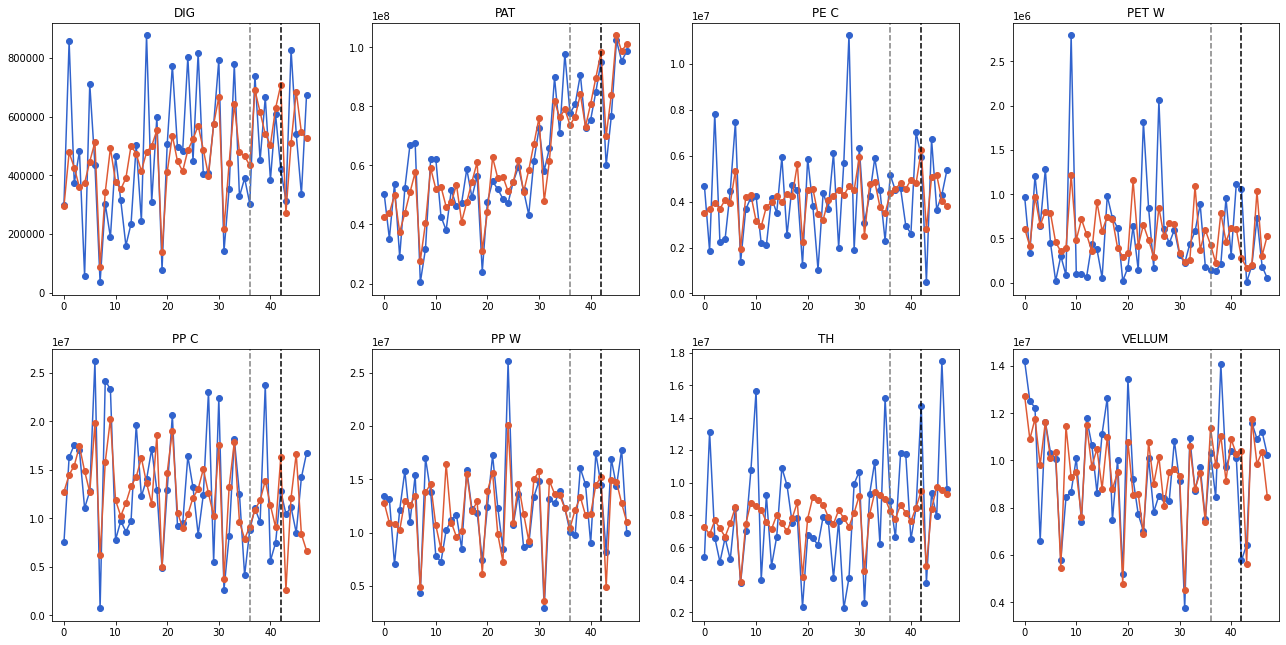

In [ ]:
fig, (ax1,ax2) = plt.subplots(2, 4, figsize=(22, 11))
  
ax1[0].plot(datatrulyready[datatrulyready["Cd Materiale"]==materials[0]]["y"].reset_index(drop=True),"o-",color="#3163cd")
ax1[0].plot(futures_dict[materials[0]]["yhat"],"o-",color="#DE5A35")
ax1[0].axvline(x=36, color="grey",linestyle="--")
ax1[0].axvline(x=42, color="black",linestyle="--")
ax1[0].set_title(materials[0])

ax1[1].plot(datatrulyready[datatrulyready["Cd Materiale"]==materials[1]]["y"].reset_index(drop=True),"o-",color="#3163cd")
ax1[1].plot(futures_dict[materials[1]]["yhat"],"o-",color="#DE5A35")
ax1[1].axvline(x=36, color="grey",linestyle="--")
ax1[1].axvline(x=42, color="black",linestyle="--")
ax1[1].set_title(materials[1])


ax1[2].plot(datatrulyready[datatrulyready["Cd Materiale"]==materials[2]]["y"].reset_index(drop=True),"o-",color="#3163cd")
ax1[2].plot(futures_dict[materials[2]]["yhat"],"o-",color="#DE5A35")
ax1[2].axvline(x=36, color="grey",linestyle="--")
ax1[2].axvline(x=42, color="black",linestyle="--")
ax1[2].set_title(materials[2])

ax1[3].plot(datatrulyready[datatrulyready["Cd Materiale"]==materials[3]]["y"].reset_index(drop=True),"o-",color="#3163cd")
ax1[3].plot(futures_dict[materials[3]]["yhat"],"o-",color="#DE5A35")
ax1[3].axvline(x=36, color="grey",linestyle="--")
ax1[3].axvline(x=42, color="black",linestyle="--")
ax1[3].set_title(materials[3])


ax2[0].plot(datatrulyready[datatrulyready["Cd Materiale"]==materials[4]]["y"].reset_index(drop=True),"o-",color="#3163cd")
ax2[0].plot(futures_dict[materials[4]]["yhat"],"o-",color="#DE5A35")
ax2[0].axvline(x=36, color="grey",linestyle="--")
ax2[0].axvline(x=42, color="black",linestyle="--")
ax2[0].set_title(materials[4])

ax2[1].plot(datatrulyready[datatrulyready["Cd Materiale"]==materials[5]]["y"].reset_index(drop=True),"o-",color="#3163cd")
ax2[1].plot(futures_dict[materials[5]]["yhat"],"o-",color="#DE5A35")
ax2[1].axvline(x=36, color="grey",linestyle="--")
ax2[1].axvline(x=42, color="black",linestyle="--")
ax2[1].set_title(materials[5])

ax2[2].plot(datatrulyready[datatrulyready["Cd Materiale"]==materials[6]]["y"].reset_index(drop=True),"o-",color="#3163cd")
ax2[2].plot(futures_dict[materials[6]]["yhat"],"o-",color="#DE5A35")
ax2[2].axvline(x=36, color="grey",linestyle="--")
ax2[2].axvline(x=42, color="black",linestyle="--")
ax2[2].set_title(materials[6])

ax2[3].plot(datatrulyready[datatrulyready["Cd Materiale"]==materials[7]]["y"].reset_index(drop=True),"o-",color="#3163cd")
ax2[3].plot(futures_dict[materials[7]]["yhat"],"o-",color="#DE5A35")
ax2[3].axvline(x=36, color="grey",linestyle="--")
ax2[3].axvline(x=42, color="black",linestyle="--")
ax2[3].set_title(materials[7])

plt.plot()

[]

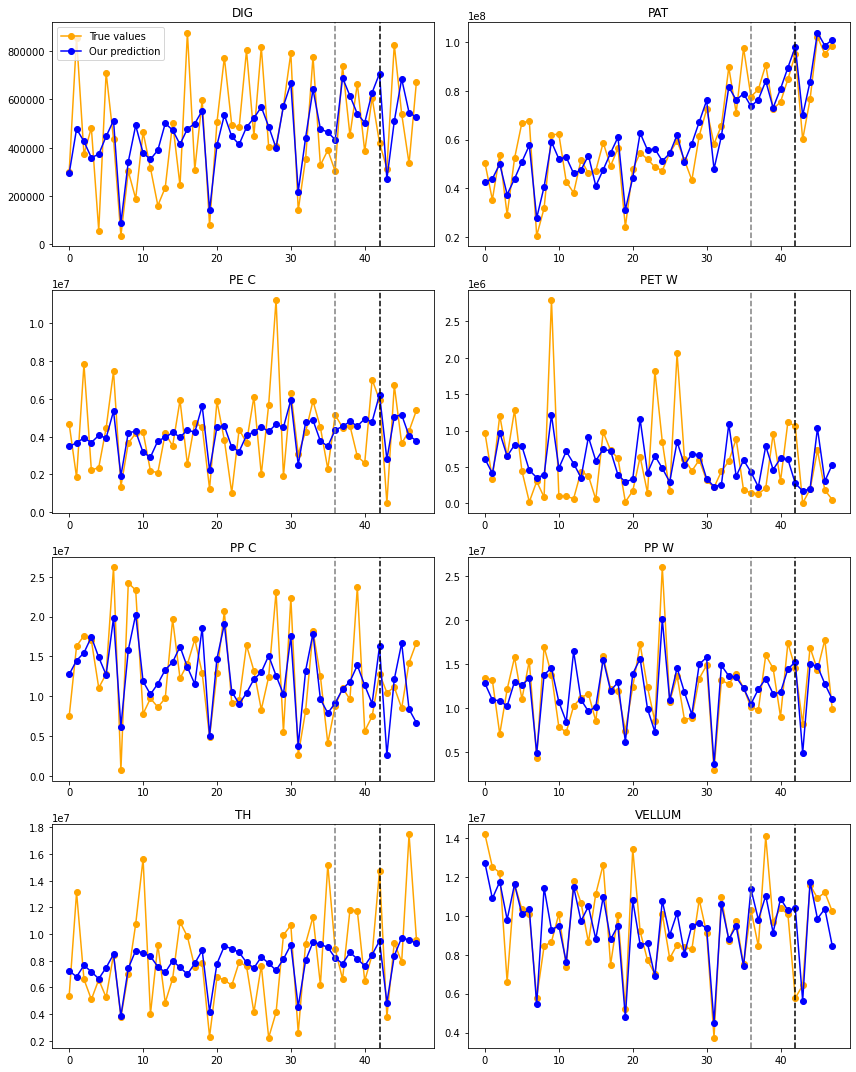

In [ ]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 2, figsize=(12, 15))
  
ax1[0].plot(datatrulyready[datatrulyready["Cd Materiale"]==materials[0]]["y"].reset_index(drop=True),"o-",color="orange", label="True values")
ax1[0].plot(futures_dict[materials[0]]["yhat"],"o-",color="blue", label="Our prediction")
ax1[0].axvline(x=36, color="grey",linestyle="--")
ax1[0].axvline(x=42, color="black",linestyle="--")
ax1[0].set_title(materials[0])
ax1[0].legend()

ax1[1].plot(datatrulyready[datatrulyready["Cd Materiale"]==materials[1]]["y"].reset_index(drop=True),"o-",color="orange")
ax1[1].plot(futures_dict[materials[1]]["yhat"],"o-",color="blue")
ax1[1].axvline(x=36, color="grey",linestyle="--")
ax1[1].axvline(x=42, color="black",linestyle="--")
ax1[1].set_title(materials[1])


ax2[0].plot(datatrulyready[datatrulyready["Cd Materiale"]==materials[2]]["y"].reset_index(drop=True),"o-",color="orange")
ax2[0].plot(futures_dict[materials[2]]["yhat"],"o-",color="blue")
ax2[0].axvline(x=36, color="grey",linestyle="--")
ax2[0].axvline(x=42, color="black",linestyle="--")
ax2[0].set_title(materials[2])

ax2[1].plot(datatrulyready[datatrulyready["Cd Materiale"]==materials[3]]["y"].reset_index(drop=True),"o-",color="orange")
ax2[1].plot(futures_dict[materials[3]]["yhat"],"o-",color="blue")
ax2[1].axvline(x=36, color="grey",linestyle="--")
ax2[1].axvline(x=42, color="black",linestyle="--")
ax2[1].set_title(materials[3])


ax3[0].plot(datatrulyready[datatrulyready["Cd Materiale"]==materials[4]]["y"].reset_index(drop=True),"o-",color="orange")
ax3[0].plot(futures_dict[materials[4]]["yhat"],"o-",color="blue")
ax3[0].axvline(x=36, color="grey",linestyle="--")
ax3[0].axvline(x=42, color="black",linestyle="--")
ax3[0].set_title(materials[4])

ax3[1].plot(datatrulyready[datatrulyready["Cd Materiale"]==materials[5]]["y"].reset_index(drop=True),"o-",color="orange")
ax3[1].plot(futures_dict[materials[5]]["yhat"],"o-",color="blue")
ax3[1].axvline(x=36, color="grey",linestyle="--")
ax3[1].axvline(x=42, color="black",linestyle="--")
ax3[1].set_title(materials[5])

ax4[0].plot(datatrulyready[datatrulyready["Cd Materiale"]==materials[6]]["y"].reset_index(drop=True),"o-",color="orange")
ax4[0].plot(futures_dict[materials[6]]["yhat"],"o-",color="blue")
ax4[0].axvline(x=36, color="grey",linestyle="--")
ax4[0].axvline(x=42, color="black",linestyle="--")
ax4[0].set_title(materials[6])

ax4[1].plot(datatrulyready[datatrulyready["Cd Materiale"]==materials[7]]["y"].reset_index(drop=True),"o-",color="orange")
ax4[1].plot(futures_dict[materials[7]]["yhat"],"o-",color="blue")
ax4[1].axvline(x=36, color="grey",linestyle="--")
ax4[1].axvline(x=42, color="black",linestyle="--")
ax4[1].set_title(materials[7])

fig.tight_layout()

plt.plot()

In [ ]:
pd.concat((datatrulyready[datatrulyready["Cd Materiale"]==materials[0]]["y"].reset_index(drop=True),futures_dict[materials[0]]["yhat"]),axis=1).iloc[42:]

,y,yhat
42,420300.0,707221.665963
43,314002.0,270849.803698
44,826300.0,509676.191598
45,540130.0,684783.922867
46,335000.0,545724.046352
47,674000.0,525677.571733


[]

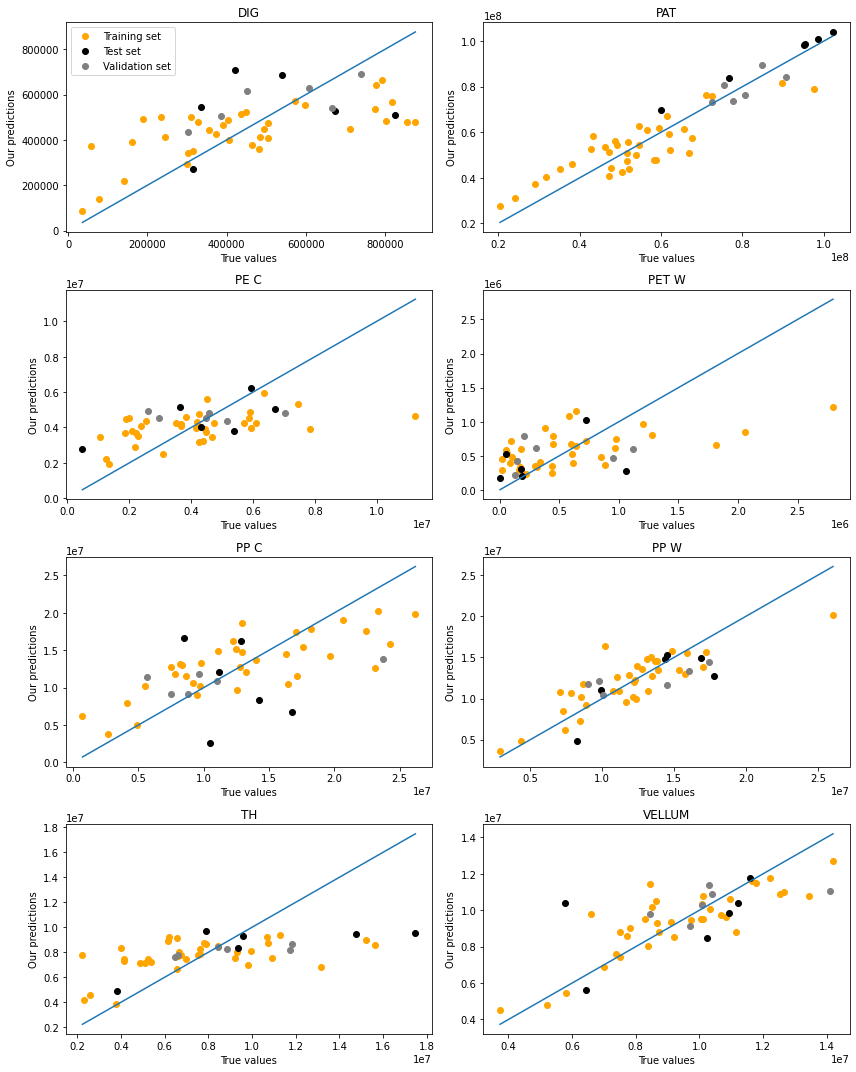

In [ ]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 2, figsize=(12, 15))


ax1[0].plot(pd.concat((datatrulyready[datatrulyready["Cd Materiale"]==materials[0]]["y"].reset_index(drop=True),futures_dict[materials[0]]["yhat"]),axis=1).iloc[0:36].set_index("y"), ".",color="orange",markersize=12, label="Training set")
ax1[0].plot(pd.concat((datatrulyready[datatrulyready["Cd Materiale"]==materials[0]]["y"].reset_index(drop=True),futures_dict[materials[0]]["yhat"]),axis=1).iloc[42:].set_index("y"), ".", color="black",markersize=12, label="Test set")
ax1[0].plot(pd.concat((datatrulyready[datatrulyready["Cd Materiale"]==materials[0]]["y"].reset_index(drop=True),futures_dict[materials[0]]["yhat"]),axis=1).iloc[36:42].set_index("y"), ".", color="grey", markersize=12, label="Validation set")
ax1[0].plot(pd.DataFrame(np.linspace(min(datatrulyready[datatrulyready["Cd Materiale"]==materials[0]]["y"]), 
                                     max(datatrulyready[datatrulyready["Cd Materiale"]==materials[0]]["y"])),
                         np.linspace(min(datatrulyready[datatrulyready["Cd Materiale"]==materials[0]]["y"]), 
                                     max(datatrulyready[datatrulyready["Cd Materiale"]==materials[0]]["y"]))))
ax1[0].set_title(materials[0])
ax1[0].legend()
ax1[0].set_xlabel("True values")
ax1[0].set_ylabel("Our predictions")



ax1[1].plot(pd.concat((datatrulyready[datatrulyready["Cd Materiale"]==materials[1]]["y"].reset_index(drop=True),futures_dict[materials[1]]["yhat"]),axis=1).iloc[0:36].set_index("y"), ".", color="orange", markersize=12)
ax1[1].plot(pd.concat((datatrulyready[datatrulyready["Cd Materiale"]==materials[1]]["y"].reset_index(drop=True),futures_dict[materials[1]]["yhat"]),axis=1).iloc[42:].set_index("y"), ".", color="black",markersize=12)
ax1[1].plot(pd.concat((datatrulyready[datatrulyready["Cd Materiale"]==materials[1]]["y"].reset_index(drop=True),futures_dict[materials[1]]["yhat"]),axis=1).iloc[36:42].set_index("y"), ".", color="grey", markersize=12)

ax1[1].plot(pd.DataFrame(np.linspace(min(datatrulyready[datatrulyready["Cd Materiale"]==materials[1]]["y"]), 
                                     max(datatrulyready[datatrulyready["Cd Materiale"]==materials[1]]["y"])),
                         np.linspace(min(datatrulyready[datatrulyready["Cd Materiale"]==materials[1]]["y"]), 
                                     max(datatrulyready[datatrulyready["Cd Materiale"]==materials[1]]["y"]))))
ax1[1].set_title(materials[1])
ax1[1].set_xlabel("True values")
ax1[1].set_ylabel("Our predictions")


ax2[0].plot(pd.concat((datatrulyready[datatrulyready["Cd Materiale"]==materials[2]]["y"].reset_index(drop=True),futures_dict[materials[2]]["yhat"]),axis=1).iloc[0:36].set_index("y"), ".", color="orange", markersize=12)
ax2[0].plot(pd.concat((datatrulyready[datatrulyready["Cd Materiale"]==materials[2]]["y"].reset_index(drop=True),futures_dict[materials[2]]["yhat"]),axis=1).iloc[42:].set_index("y"), ".", color="black",markersize=12)
ax2[0].plot(pd.concat((datatrulyready[datatrulyready["Cd Materiale"]==materials[2]]["y"].reset_index(drop=True),futures_dict[materials[2]]["yhat"]),axis=1).iloc[36:42].set_index("y"), ".", color="grey", markersize=12)
ax2[0].plot(pd.DataFrame(np.linspace(min(datatrulyready[datatrulyready["Cd Materiale"]==materials[2]]["y"]), 
                                     max(datatrulyready[datatrulyready["Cd Materiale"]==materials[2]]["y"])),
                         np.linspace(min(datatrulyready[datatrulyready["Cd Materiale"]==materials[2]]["y"]), 
                                     max(datatrulyready[datatrulyready["Cd Materiale"]==materials[2]]["y"]))))
ax2[0].set_title(materials[2])
ax2[0].set_xlabel("True values")
ax2[0].set_ylabel("Our predictions")



ax2[1].plot(pd.concat((datatrulyready[datatrulyready["Cd Materiale"]==materials[3]]["y"].reset_index(drop=True),futures_dict[materials[3]]["yhat"]),axis=1).iloc[0:36].set_index("y"), ".", color="orange", markersize=12)
ax2[1].plot(pd.concat((datatrulyready[datatrulyready["Cd Materiale"]==materials[3]]["y"].reset_index(drop=True),futures_dict[materials[3]]["yhat"]),axis=1).iloc[42:].set_index("y"), ".", color="black",markersize=12)
ax2[1].plot(pd.concat((datatrulyready[datatrulyready["Cd Materiale"]==materials[3]]["y"].reset_index(drop=True),futures_dict[materials[3]]["yhat"]),axis=1).iloc[36:42].set_index("y"), ".", color="grey", markersize=12)
ax2[1].plot(pd.DataFrame(np.linspace(min(datatrulyready[datatrulyready["Cd Materiale"]==materials[3]]["y"]), 
                                     max(datatrulyready[datatrulyready["Cd Materiale"]==materials[3]]["y"])),
                         np.linspace(min(datatrulyready[datatrulyready["Cd Materiale"]==materials[3]]["y"]), 
                                     max(datatrulyready[datatrulyready["Cd Materiale"]==materials[3]]["y"]))))
ax2[1].set_title(materials[3])
ax2[1].set_xlabel("True values")
ax2[1].set_ylabel("Our predictions")

ax3[0].plot(pd.concat((datatrulyready[datatrulyready["Cd Materiale"]==materials[4]]["y"].reset_index(drop=True),futures_dict[materials[4]]["yhat"]),axis=1).iloc[0:36].set_index("y"), ".", color="orange", markersize=12)
ax3[0].plot(pd.concat((datatrulyready[datatrulyready["Cd Materiale"]==materials[4]]["y"].reset_index(drop=True),futures_dict[materials[4]]["yhat"]),axis=1).iloc[42:].set_index("y"), ".", color="black",markersize=12)
ax3[0].plot(pd.concat((datatrulyready[datatrulyready["Cd Materiale"]==materials[4]]["y"].reset_index(drop=True),futures_dict[materials[4]]["yhat"]),axis=1).iloc[36:42].set_index("y"), ".", color="grey", markersize=12)
ax3[0].plot(pd.DataFrame(np.linspace(min(datatrulyready[datatrulyready["Cd Materiale"]==materials[4]]["y"]), 
                                     max(datatrulyready[datatrulyready["Cd Materiale"]==materials[4]]["y"])),
                         np.linspace(min(datatrulyready[datatrulyready["Cd Materiale"]==materials[4]]["y"]), 
                                     max(datatrulyready[datatrulyready["Cd Materiale"]==materials[4]]["y"]))))
ax3[0].set_title(materials[4])
ax3[0].set_xlabel("True values")
ax3[0].set_ylabel("Our predictions")



ax3[1].plot(pd.concat((datatrulyready[datatrulyready["Cd Materiale"]==materials[5]]["y"].reset_index(drop=True),futures_dict[materials[5]]["yhat"]),axis=1).iloc[0:36].set_index("y"), ".", color="orange", markersize=12)
ax3[1].plot(pd.concat((datatrulyready[datatrulyready["Cd Materiale"]==materials[5]]["y"].reset_index(drop=True),futures_dict[materials[5]]["yhat"]),axis=1).iloc[42:].set_index("y"), ".", color="black",markersize=12)
ax3[1].plot(pd.concat((datatrulyready[datatrulyready["Cd Materiale"]==materials[5]]["y"].reset_index(drop=True),futures_dict[materials[5]]["yhat"]),axis=1).iloc[36:42].set_index("y"), ".", color="grey", markersize=12)
ax3[1].plot(pd.DataFrame(np.linspace(min(datatrulyready[datatrulyready["Cd Materiale"]==materials[5]]["y"]), 
                                     max(datatrulyready[datatrulyready["Cd Materiale"]==materials[5]]["y"])),
                         np.linspace(min(datatrulyready[datatrulyready["Cd Materiale"]==materials[5]]["y"]), 
                                     max(datatrulyready[datatrulyready["Cd Materiale"]==materials[5]]["y"]))))
ax3[1].set_title(materials[5])
ax3[1].set_xlabel("True values")
ax3[1].set_ylabel("Our predictions")

ax4[0].plot(pd.concat((datatrulyready[datatrulyready["Cd Materiale"]==materials[6]]["y"].reset_index(drop=True),futures_dict[materials[6]]["yhat"]),axis=1).iloc[0:36].set_index("y"), ".", color="orange", markersize=12)
ax4[0].plot(pd.concat((datatrulyready[datatrulyready["Cd Materiale"]==materials[6]]["y"].reset_index(drop=True),futures_dict[materials[6]]["yhat"]),axis=1).iloc[42:].set_index("y"), ".", color="black",markersize=12)
ax4[0].plot(pd.concat((datatrulyready[datatrulyready["Cd Materiale"]==materials[6]]["y"].reset_index(drop=True),futures_dict[materials[6]]["yhat"]),axis=1).iloc[36:42].set_index("y"), ".", color="grey", markersize=12)
ax4[0].plot(pd.DataFrame(np.linspace(min(datatrulyready[datatrulyready["Cd Materiale"]==materials[6]]["y"]), 
                                     max(datatrulyready[datatrulyready["Cd Materiale"]==materials[6]]["y"])),
                         np.linspace(min(datatrulyready[datatrulyready["Cd Materiale"]==materials[6]]["y"]), 
                                     max(datatrulyready[datatrulyready["Cd Materiale"]==materials[6]]["y"]))))
ax4[0].set_title(materials[6])
ax4[0].set_xlabel("True values")
ax4[0].set_ylabel("Our predictions")



ax4[1].plot(pd.concat((datatrulyready[datatrulyready["Cd Materiale"]==materials[7]]["y"].reset_index(drop=True),futures_dict[materials[7]]["yhat"]),axis=1).iloc[0:36].set_index("y"), ".", color="orange", markersize=12)
ax4[1].plot(pd.concat((datatrulyready[datatrulyready["Cd Materiale"]==materials[7]]["y"].reset_index(drop=True),futures_dict[materials[7]]["yhat"]),axis=1).iloc[42:].set_index("y"), ".", color="black",markersize=12)
ax4[1].plot(pd.concat((datatrulyready[datatrulyready["Cd Materiale"]==materials[7]]["y"].reset_index(drop=True),futures_dict[materials[7]]["yhat"]),axis=1).iloc[36:42].set_index("y"), ".", color="grey", markersize=12)
ax4[1].plot(pd.DataFrame(np.linspace(min(datatrulyready[datatrulyready["Cd Materiale"]==materials[7]]["y"]), 
                                     max(datatrulyready[datatrulyready["Cd Materiale"]==materials[7]]["y"])),
                         np.linspace(min(datatrulyready[datatrulyready["Cd Materiale"]==materials[7]]["y"]), 
                                     max(datatrulyready[datatrulyready["Cd Materiale"]==materials[7]]["y"]))))
ax4[1].set_title(materials[7])
ax4[1].set_xlabel("True values")
ax4[1].set_ylabel("Our predictions")

fig.tight_layout()

plt.plot()



In [ ]:
type(m[7])

prophet.forecaster.Prophet

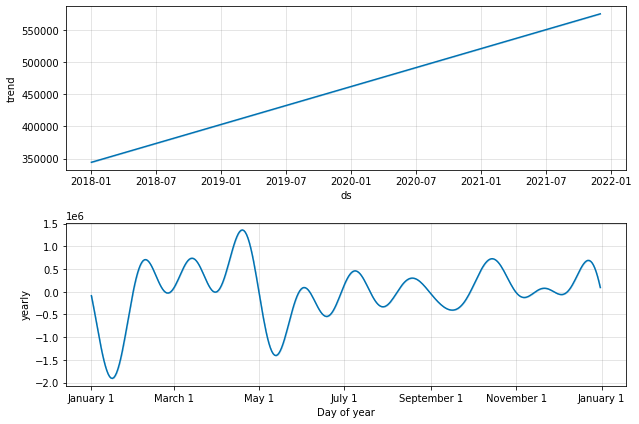

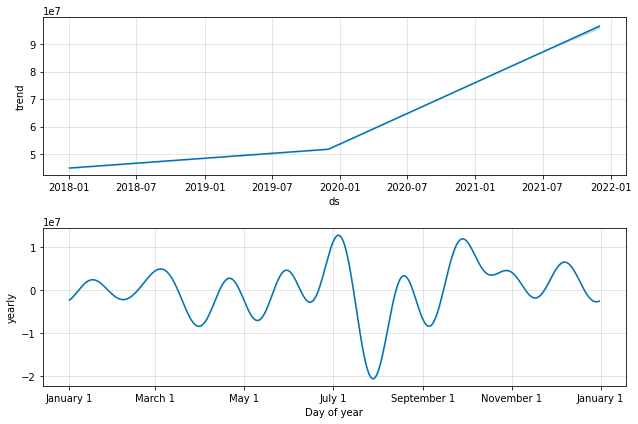

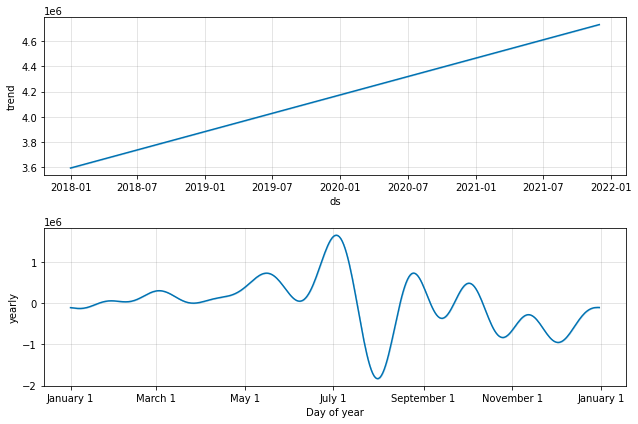

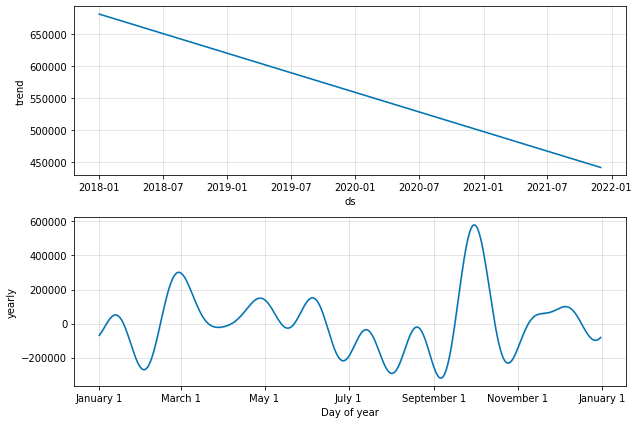

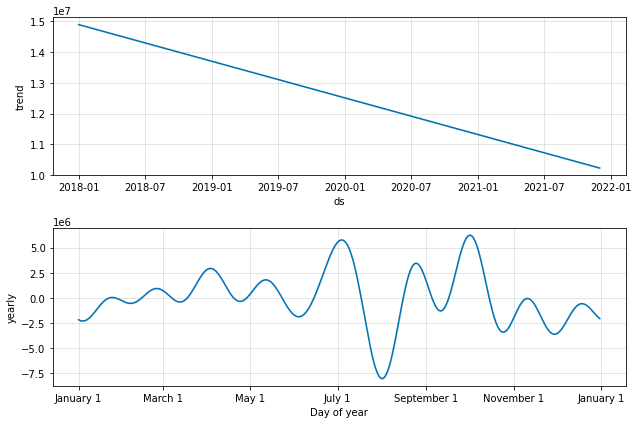

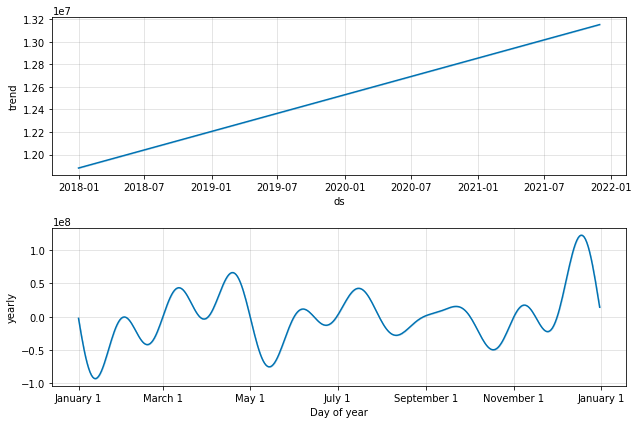

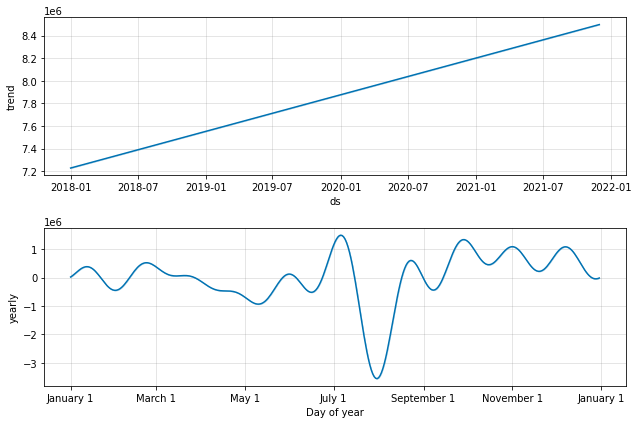

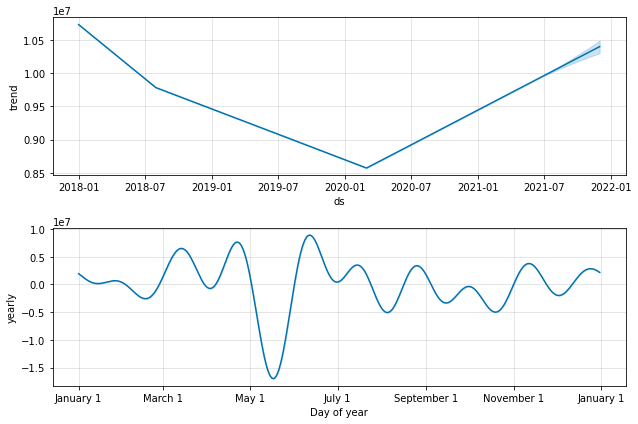

In [ ]:
fig0=m[0].plot_components(futures_dict[materials[0]])
fig1=m[1].plot_components(futures_dict[materials[1]])
fig1=m[2].plot_components(futures_dict[materials[2]])
fig1=m[3].plot_components(futures_dict[materials[3]])
fig1=m[4].plot_components(futures_dict[materials[4]])
fig1=m[5].plot_components(futures_dict[materials[5]])
fig1=m[6].plot_components(futures_dict[materials[6]])
fig1=m[7].plot_components(futures_dict[materials[7]])


# Predictions Comparison

We now compare the performance of our model with the company's predictions.

In [ ]:
res=compare_predictions(futures_dict,company_estimations)

In [ ]:
print(f"""The MAE% of our predictions are: \n
          {res[0]} \n
          The MAE% of the company's predictions are: \n
          {res[1]}
          The differences between the MAE% of our predictions and the company's one for each time series are: \n
          {res[2]} \n
          The p-values related to them are: \n
          {res[3]} \n
          The ATE is: {res[4]} \n
          Its z-value is: {res[5]}""")

The MAE% of our predictions are: 

          [0.36993479 0.05265295 0.28816685 0.84262395 0.49227679 0.15289489
 0.27544153 0.16443051] 

          The MAE% of the company's predictions are: 

          [0.51093535 0.5264991  0.61266444 0.85991866 0.67523292 0.59162126
 0.63783438 0.31378683]
          The differences between the MAE% of our predictions and the company's one for each time series are: 

          [-0.14100055 -0.47384615 -0.32449759 -0.01729472 -0.18295613 -0.43872636
 -0.36239286 -0.14935632] 

          The p-values related to them are: 

          [0.32347687 0.01127002 0.03542567 0.59566229 0.09189359 0.00463851
 0.02610143 0.10441293] 

          The ATE is: -0.2612588345334531 

          Its z-value is: -17.125898219154454


# Further Test

As a further robustness check we fit the model on a shorter period using the rest of the training data as test.

In [ ]:
nnew_train=datatrulyready[(datatrulyready["ds"]<=pd.Timestamp(2020,6,1))]
plot_data=datatrulyready[(datatrulyready["ds"]<=pd.Timestamp(2020,12,1))]
new_test=datatrulyready[((datatrulyready["ds"]<=pd.Timestamp(2020,12,1))& (datatrulyready["ds"]>=pd.Timestamp(2020,7,1)))]

In [ ]:
nfutures_dict=dict()
ntest_errordict=dict()
m_n=list()
for i in miniv:
  m_n.append(Prophet(changepoint_prior_scale=i[0], seasonality_prior_scale=i[1], changepoint_range=i[2], weekly_seasonality=False, daily_seasonality=False))

for i in range(len(materials)):

    m_n[i].fit(nnew_train[nnew_train["Cd Materiale"]==materials[i]])

    future=m_n[i].make_future_dataframe(periods=6, freq="MS")

    futures=m_n[i].predict(future)

    ntest_errordict[materials[i]]=test_errorf(futures["yhat"].iloc[30:],new_test,material=materials[i])
    nfutures_dict[materials[i]]=futures

INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 23.


We look at the results.

In [ ]:
ntest_errordict

{'DIG': (0.3661636461904767, 0.3952473419547006, 0.31094375638157484),
 'PAT': (0.329899638670186, 0.3724431293643022, 0.15733787358571547),
 'PE C': (0.21340840501006783, 0.23959643879976983, 0.21967772446707964),
 'PET W': (0.92564236118363, 1.1193289413555096, 0.8859718509406413),
 'PP C': (0.3535935274481341, 0.4160908835154487, 0.42914025490395413),
 'PP W': (0.282158275358753, 0.3353594328162478, 0.4747981984817981),
 'TH': (0.4515615276208384, 0.5540168287447442, 0.1747401265787876),
 'VELLUM': (0.14130273279395028, 0.1581723776068002, 0.20550290458836395)}

### Plots

We plot the results

[]

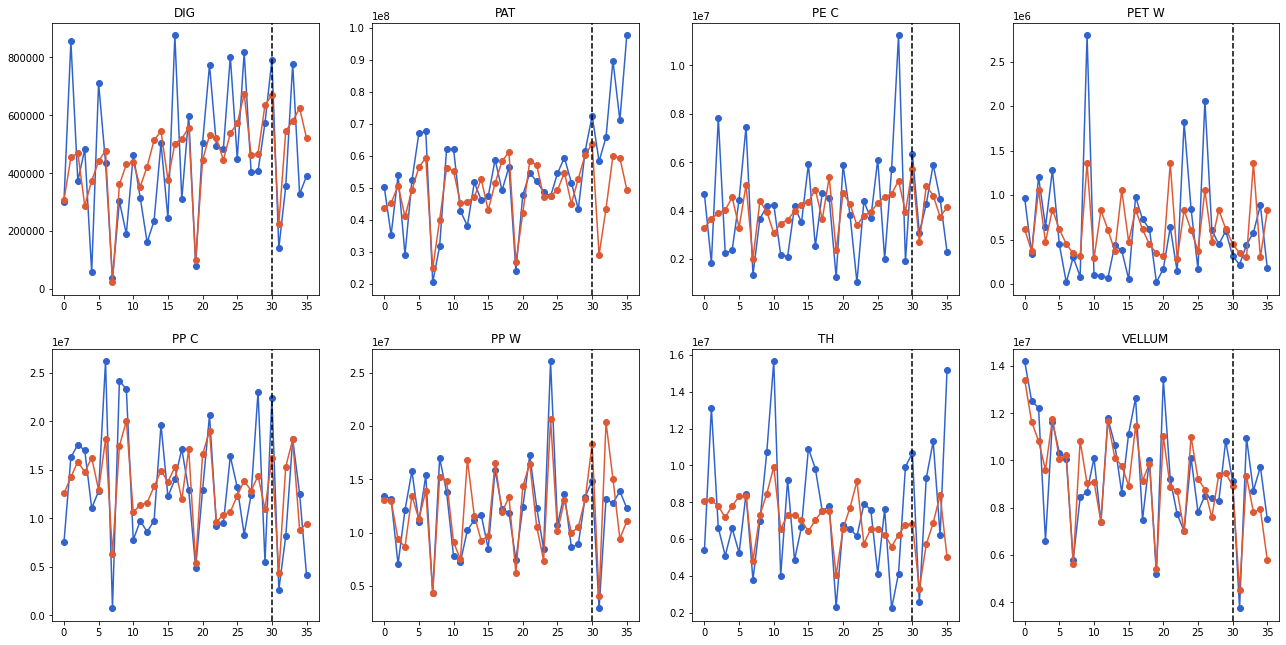

In [ ]:
fig, (ax1,ax2) = plt.subplots(2, 4, figsize=(22, 11))
  
ax1[0].plot(plot_data[plot_data["Cd Materiale"]==materials[0]]["y"].reset_index(drop=True),"o-",color="#3163cd")
ax1[0].plot(nfutures_dict[materials[0]]["yhat"],"o-",color="#DE5A35")
ax1[0].axvline(x=30, color="black",linestyle="--")
ax1[0].set_title(materials[0])

ax1[1].plot(plot_data[plot_data["Cd Materiale"]==materials[1]]["y"].reset_index(drop=True),"o-",color="#3163cd")
ax1[1].plot(nfutures_dict[materials[1]]["yhat"],"o-",color="#DE5A35")
ax1[1].axvline(x=30, color="black",linestyle="--")
ax1[1].set_title(materials[1])


ax1[2].plot(plot_data[plot_data["Cd Materiale"]==materials[2]]["y"].reset_index(drop=True),"o-",color="#3163cd")
ax1[2].plot(nfutures_dict[materials[2]]["yhat"],"o-",color="#DE5A35")
ax1[2].axvline(x=30, color="black",linestyle="--")
ax1[2].set_title(materials[2])


ax1[3].plot(plot_data[plot_data["Cd Materiale"]==materials[3]]["y"].reset_index(drop=True),"o-",color="#3163cd")
ax1[3].plot(nfutures_dict[materials[3]]["yhat"],"o-",color="#DE5A35")
ax1[3].axvline(x=30, color="black",linestyle="--")
ax1[3].set_title(materials[3])


ax2[0].plot(plot_data[plot_data["Cd Materiale"]==materials[4]]["y"].reset_index(drop=True),"o-",color="#3163cd")
ax2[0].plot(nfutures_dict[materials[4]]["yhat"],"o-",color="#DE5A35")
ax2[0].axvline(x=30, color="black",linestyle="--")
ax2[0].set_title(materials[4])


ax2[1].plot(plot_data[plot_data["Cd Materiale"]==materials[5]]["y"].reset_index(drop=True),"o-",color="#3163cd")
ax2[1].plot(nfutures_dict[materials[5]]["yhat"],"o-",color="#DE5A35")
ax2[1].axvline(x=30, color="black",linestyle="--")
ax2[1].set_title(materials[5])


ax2[2].plot(plot_data[plot_data["Cd Materiale"]==materials[6]]["y"].reset_index(drop=True),"o-",color="#3163cd")
ax2[2].plot(nfutures_dict[materials[6]]["yhat"],"o-",color="#DE5A35")
ax2[2].axvline(x=30, color="black",linestyle="--")
ax2[2].set_title(materials[6])


ax2[3].plot(plot_data[plot_data["Cd Materiale"]==materials[7]]["y"].reset_index(drop=True),"o-",color="#3163cd")
ax2[3].plot(nfutures_dict[materials[7]]["yhat"],"o-",color="#DE5A35")
ax2[3].axvline(x=30, color="black",linestyle="--")
ax2[3].set_title(materials[7])

plt.plot()

[]

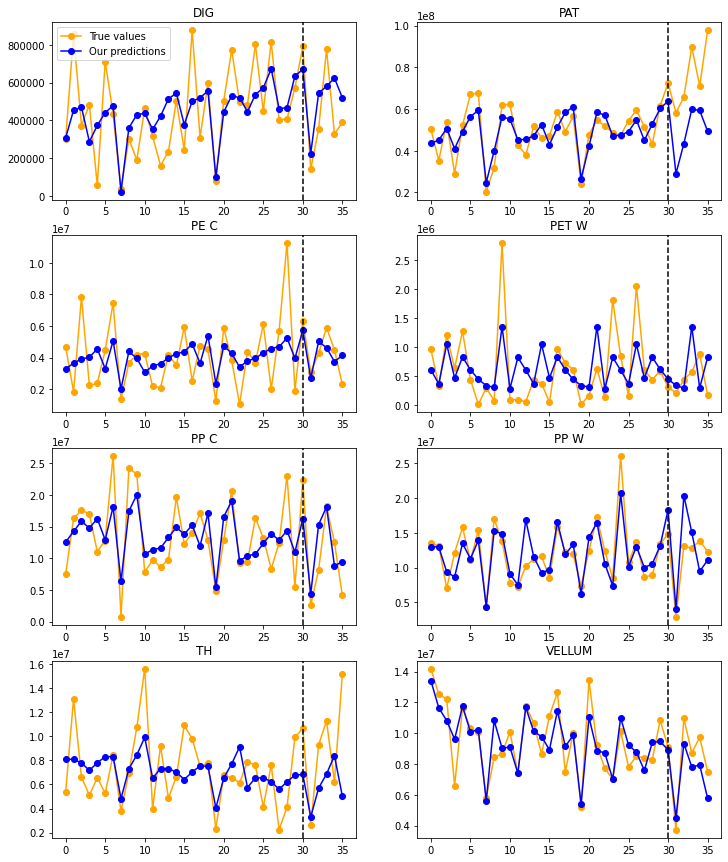

In [ ]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 2, figsize=(12, 15))
  
ax1[0].plot(plot_data[plot_data["Cd Materiale"]==materials[0]]["y"].reset_index(drop=True),"o-",color="orange",label="True values")
ax1[0].plot(nfutures_dict[materials[0]]["yhat"],"o-",color="blue", label="Our predictions")
ax1[0].axvline(x=30, color="black",linestyle="--")
ax1[0].set_title(materials[0])
ax1[0].legend()

ax1[1].plot(plot_data[plot_data["Cd Materiale"]==materials[1]]["y"].reset_index(drop=True),"o-",color="orange")
ax1[1].plot(nfutures_dict[materials[1]]["yhat"],"o-",color="blue")
ax1[1].axvline(x=30, color="black",linestyle="--")
ax1[1].set_title(materials[1])


ax2[0].plot(plot_data[plot_data["Cd Materiale"]==materials[2]]["y"].reset_index(drop=True),"o-",color="orange")
ax2[0].plot(nfutures_dict[materials[2]]["yhat"],"o-",color="blue")
ax2[0].axvline(x=30, color="black",linestyle="--")
ax2[0].set_title(materials[2])


ax2[1].plot(plot_data[plot_data["Cd Materiale"]==materials[3]]["y"].reset_index(drop=True),"o-",color="orange")
ax2[1].plot(nfutures_dict[materials[3]]["yhat"],"o-",color="blue")
ax2[1].axvline(x=30, color="black",linestyle="--")
ax2[1].set_title(materials[3])


ax3[0].plot(plot_data[plot_data["Cd Materiale"]==materials[4]]["y"].reset_index(drop=True),"o-",color="orange")
ax3[0].plot(nfutures_dict[materials[4]]["yhat"],"o-",color="blue")
ax3[0].axvline(x=30, color="black",linestyle="--")
ax3[0].set_title(materials[4])


ax3[1].plot(plot_data[plot_data["Cd Materiale"]==materials[5]]["y"].reset_index(drop=True),"o-",color="orange")
ax3[1].plot(nfutures_dict[materials[5]]["yhat"],"o-",color="blue")
ax3[1].axvline(x=30, color="black",linestyle="--")
ax3[1].set_title(materials[5])


ax4[0].plot(plot_data[plot_data["Cd Materiale"]==materials[6]]["y"].reset_index(drop=True),"o-",color="orange")
ax4[0].plot(nfutures_dict[materials[6]]["yhat"],"o-",color="blue")
ax4[0].axvline(x=30, color="black",linestyle="--")
ax4[0].set_title(materials[6])


ax4[1].plot(plot_data[plot_data["Cd Materiale"]==materials[7]]["y"].reset_index(drop=True),"o-",color="orange")
ax4[1].plot(nfutures_dict[materials[7]]["yhat"],"o-",color="blue")
ax4[1].axvline(x=30, color="black",linestyle="--")
ax4[1].set_title(materials[7])

plt.plot()

[]

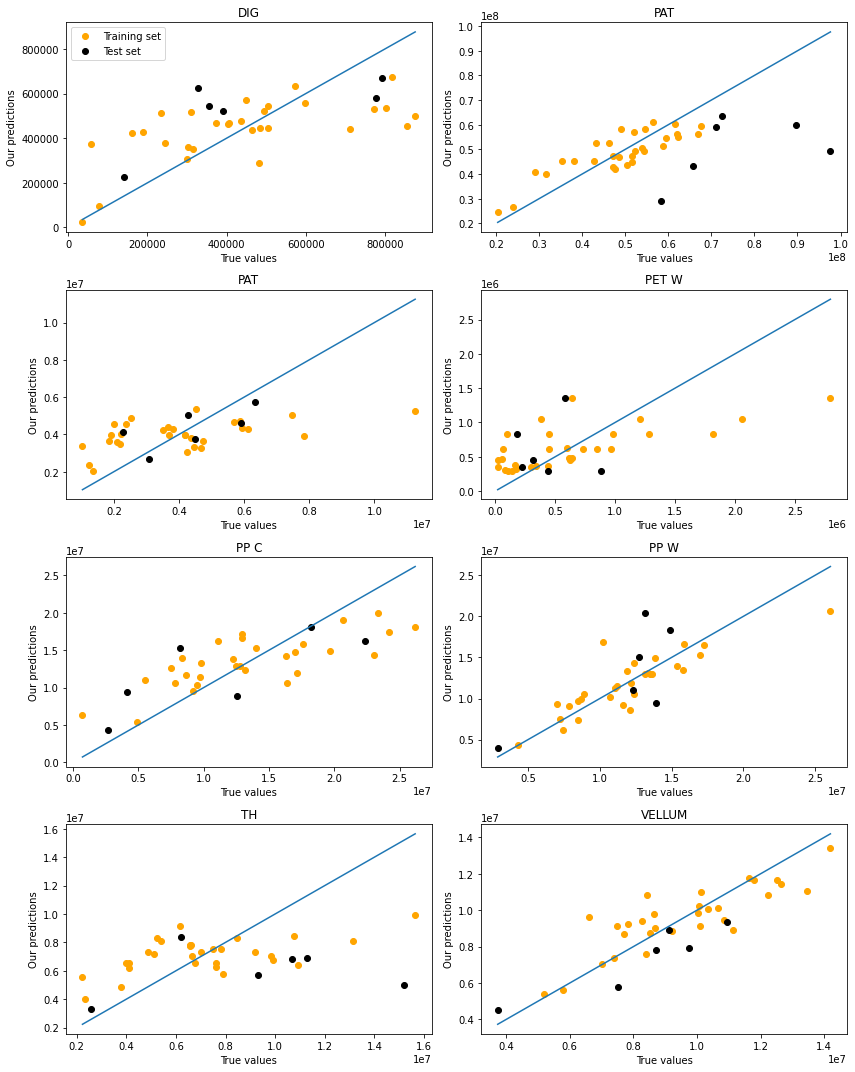

In [ ]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 2, figsize=(12, 15))


ax1[0].plot(pd.concat((plot_data[plot_data["Cd Materiale"]==materials[0]]["y"].reset_index(drop=True),nfutures_dict[materials[0]]["yhat"]),axis=1).iloc[0:30].set_index("y"), ".",color="orange",markersize=12, label="Training set")
ax1[0].plot(pd.concat((plot_data[plot_data["Cd Materiale"]==materials[0]]["y"].reset_index(drop=True),nfutures_dict[materials[0]]["yhat"]),axis=1).iloc[30:].set_index("y"), ".", color="black",markersize=12, label="Test set")
ax1[0].plot(pd.DataFrame(np.linspace(min(plot_data[plot_data["Cd Materiale"]==materials[0]]["y"]), 
                                     max(plot_data[plot_data["Cd Materiale"]==materials[0]]["y"])),
                         np.linspace(min(plot_data[plot_data["Cd Materiale"]==materials[0]]["y"]), 
                                     max(plot_data[plot_data["Cd Materiale"]==materials[0]]["y"]))))
ax1[0].set_title(materials[0])
ax1[0].legend()
ax1[0].set_xlabel("True values")
ax1[0].set_ylabel("Our predictions")

ax1[1].plot(pd.concat((plot_data[plot_data["Cd Materiale"]==materials[1]]["y"].reset_index(drop=True),nfutures_dict[materials[1]]["yhat"]),axis=1).iloc[0:30].set_index("y"), ".",color="orange",markersize=12)
ax1[1].plot(pd.concat((plot_data[plot_data["Cd Materiale"]==materials[1]]["y"].reset_index(drop=True),nfutures_dict[materials[1]]["yhat"]),axis=1).iloc[30:].set_index("y"), ".", color="black",markersize=12)
ax1[1].plot(pd.DataFrame(np.linspace(min(plot_data[plot_data["Cd Materiale"]==materials[1]]["y"]), 
                                     max(plot_data[plot_data["Cd Materiale"]==materials[1]]["y"])),
                         np.linspace(min(plot_data[plot_data["Cd Materiale"]==materials[1]]["y"]), 
                                     max(plot_data[plot_data["Cd Materiale"]==materials[1]]["y"]))))
ax1[1].set_title(materials[1])
ax1[1].set_xlabel("True values")
ax1[1].set_ylabel("Our predictions")


ax2[0].plot(pd.concat((plot_data[plot_data["Cd Materiale"]==materials[2]]["y"].reset_index(drop=True),nfutures_dict[materials[2]]["yhat"]),axis=1).iloc[0:30].set_index("y"), ".",color="orange",markersize=12)
ax2[0].plot(pd.concat((plot_data[plot_data["Cd Materiale"]==materials[2]]["y"].reset_index(drop=True),nfutures_dict[materials[2]]["yhat"]),axis=1).iloc[30:].set_index("y"), ".", color="black",markersize=12)
ax2[0].plot(pd.DataFrame(np.linspace(min(plot_data[plot_data["Cd Materiale"]==materials[2]]["y"]), 
                                     max(plot_data[plot_data["Cd Materiale"]==materials[2]]["y"])),
                         np.linspace(min(plot_data[plot_data["Cd Materiale"]==materials[2]]["y"]), 
                                     max(plot_data[plot_data["Cd Materiale"]==materials[2]]["y"]))))
ax2[0].set_title(materials[1])
ax2[0].set_xlabel("True values")
ax2[0].set_ylabel("Our predictions")

ax2[1].plot(pd.concat((plot_data[plot_data["Cd Materiale"]==materials[3]]["y"].reset_index(drop=True),nfutures_dict[materials[3]]["yhat"]),axis=1).iloc[0:30].set_index("y"), ".",color="orange",markersize=12)
ax2[1].plot(pd.concat((plot_data[plot_data["Cd Materiale"]==materials[3]]["y"].reset_index(drop=True),nfutures_dict[materials[3]]["yhat"]),axis=1).iloc[30:].set_index("y"), ".", color="black",markersize=12)
ax2[1].plot(pd.DataFrame(np.linspace(min(plot_data[plot_data["Cd Materiale"]==materials[3]]["y"]), 
                                     max(plot_data[plot_data["Cd Materiale"]==materials[3]]["y"])),
                         np.linspace(min(plot_data[plot_data["Cd Materiale"]==materials[3]]["y"]), 
                                     max(plot_data[plot_data["Cd Materiale"]==materials[3]]["y"]))))
ax2[1].set_title(materials[3])
ax2[1].set_xlabel("True values")
ax2[1].set_ylabel("Our predictions")

ax3[0].plot(pd.concat((plot_data[plot_data["Cd Materiale"]==materials[4]]["y"].reset_index(drop=True),nfutures_dict[materials[4]]["yhat"]),axis=1).iloc[0:30].set_index("y"), ".",color="orange",markersize=12)
ax3[0].plot(pd.concat((plot_data[plot_data["Cd Materiale"]==materials[4]]["y"].reset_index(drop=True),nfutures_dict[materials[4]]["yhat"]),axis=1).iloc[30:].set_index("y"), ".", color="black",markersize=12)
ax3[0].plot(pd.DataFrame(np.linspace(min(plot_data[plot_data["Cd Materiale"]==materials[4]]["y"]), 
                                     max(plot_data[plot_data["Cd Materiale"]==materials[4]]["y"])),
                         np.linspace(min(plot_data[plot_data["Cd Materiale"]==materials[4]]["y"]), 
                                     max(plot_data[plot_data["Cd Materiale"]==materials[4]]["y"]))))
ax3[0].set_title(materials[4])
ax3[0].set_xlabel("True values")
ax3[0].set_ylabel("Our predictions")

ax3[1].plot(pd.concat((plot_data[plot_data["Cd Materiale"]==materials[5]]["y"].reset_index(drop=True),nfutures_dict[materials[5]]["yhat"]),axis=1).iloc[0:30].set_index("y"), ".",color="orange",markersize=12)
ax3[1].plot(pd.concat((plot_data[plot_data["Cd Materiale"]==materials[5]]["y"].reset_index(drop=True),nfutures_dict[materials[5]]["yhat"]),axis=1).iloc[30:].set_index("y"), ".", color="black",markersize=12)
ax3[1].plot(pd.DataFrame(np.linspace(min(plot_data[plot_data["Cd Materiale"]==materials[5]]["y"]), 
                                     max(plot_data[plot_data["Cd Materiale"]==materials[5]]["y"])),
                         np.linspace(min(plot_data[plot_data["Cd Materiale"]==materials[5]]["y"]), 
                                     max(plot_data[plot_data["Cd Materiale"]==materials[5]]["y"]))))
ax3[1].set_title(materials[5])
ax3[1].set_xlabel("True values")
ax3[1].set_ylabel("Our predictions")

ax4[0].plot(pd.concat((plot_data[plot_data["Cd Materiale"]==materials[6]]["y"].reset_index(drop=True),nfutures_dict[materials[6]]["yhat"]),axis=1).iloc[0:30].set_index("y"), ".",color="orange",markersize=12)
ax4[0].plot(pd.concat((plot_data[plot_data["Cd Materiale"]==materials[6]]["y"].reset_index(drop=True),nfutures_dict[materials[6]]["yhat"]),axis=1).iloc[30:].set_index("y"), ".", color="black",markersize=12)
ax4[0].plot(pd.DataFrame(np.linspace(min(plot_data[plot_data["Cd Materiale"]==materials[6]]["y"]), 
                                     max(plot_data[plot_data["Cd Materiale"]==materials[6]]["y"])),
                         np.linspace(min(plot_data[plot_data["Cd Materiale"]==materials[6]]["y"]), 
                                     max(plot_data[plot_data["Cd Materiale"]==materials[6]]["y"]))))
ax4[0].set_title(materials[6])
ax4[0].set_xlabel("True values")
ax4[0].set_ylabel("Our predictions")

ax4[1].plot(pd.concat((plot_data[plot_data["Cd Materiale"]==materials[7]]["y"].reset_index(drop=True),nfutures_dict[materials[7]]["yhat"]),axis=1).iloc[0:30].set_index("y"), ".",color="orange",markersize=12)
ax4[1].plot(pd.concat((plot_data[plot_data["Cd Materiale"]==materials[7]]["y"].reset_index(drop=True),nfutures_dict[materials[7]]["yhat"]),axis=1).iloc[30:].set_index("y"), ".", color="black",markersize=12)
ax4[1].plot(pd.DataFrame(np.linspace(min(plot_data[plot_data["Cd Materiale"]==materials[7]]["y"]), 
                                     max(plot_data[plot_data["Cd Materiale"]==materials[7]]["y"])),
                         np.linspace(min(plot_data[plot_data["Cd Materiale"]==materials[7]]["y"]), 
                                     max(plot_data[plot_data["Cd Materiale"]==materials[7]]["y"]))))
ax4[1].set_title(materials[7])
ax4[1].set_xlabel("True values")
ax4[1].set_ylabel("Our predictions")

fig.tight_layout()

plt.plot()


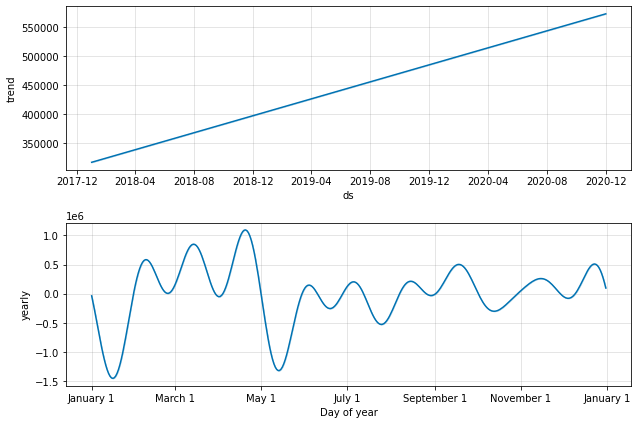

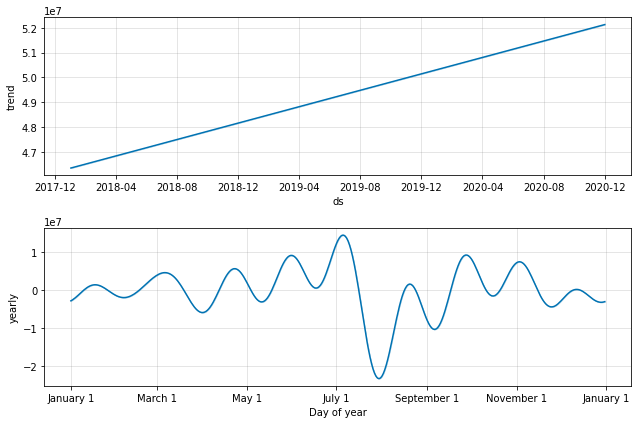

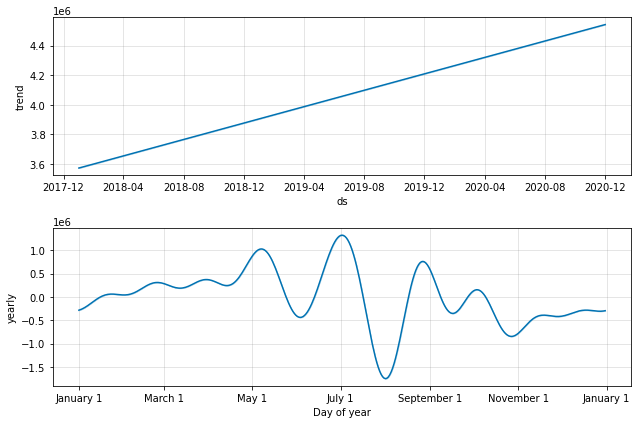

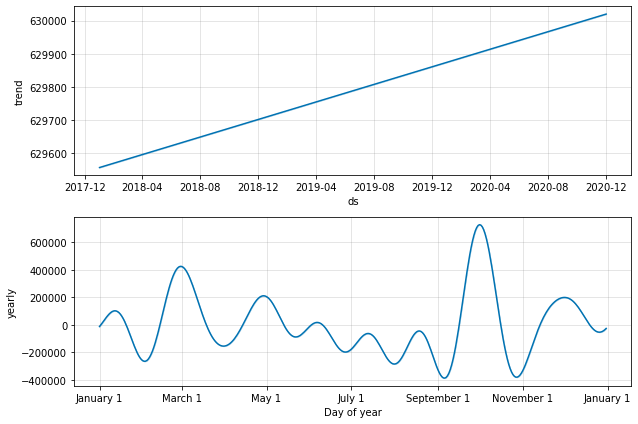

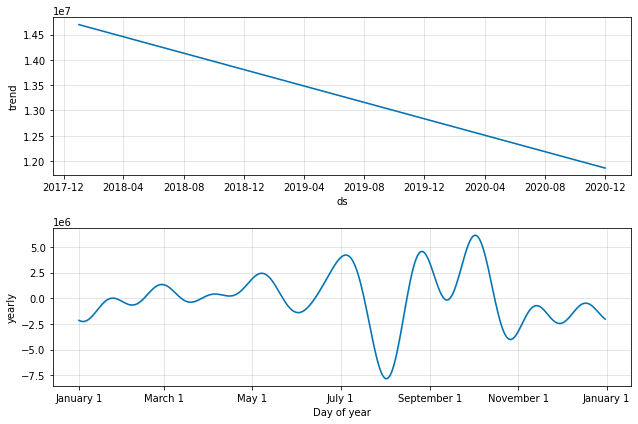

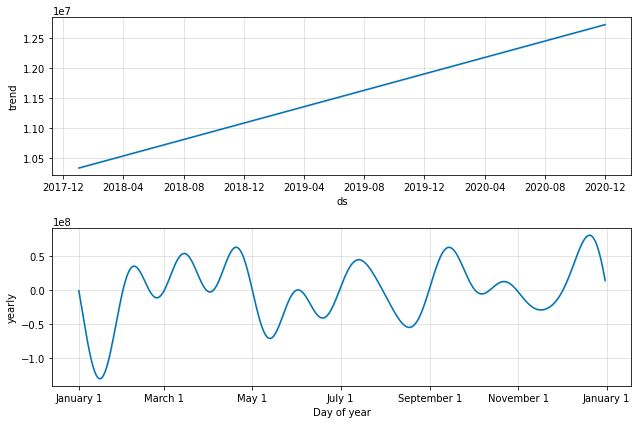

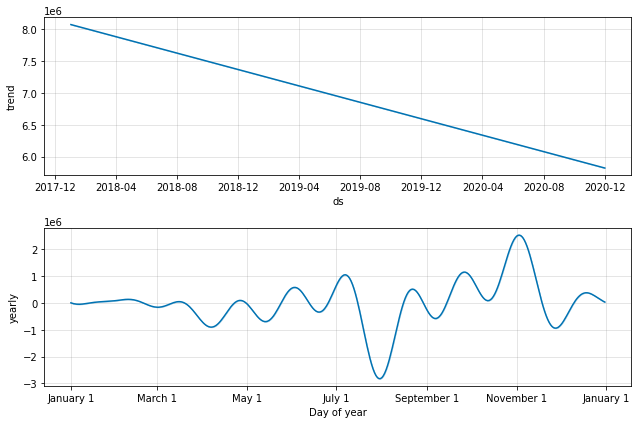

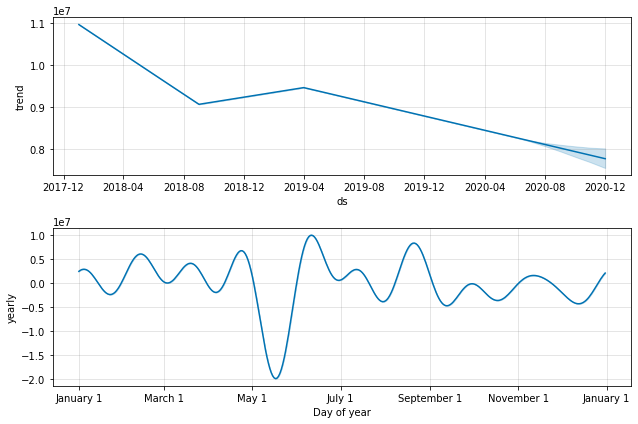

In [ ]:
fig0=m_n[0].plot_components(nfutures_dict[materials[0]])
fig1=m_n[1].plot_components(nfutures_dict[materials[1]])
fig1=m_n[2].plot_components(nfutures_dict[materials[2]])
fig1=m_n[3].plot_components(nfutures_dict[materials[3]])
fig1=m_n[4].plot_components(nfutures_dict[materials[4]])
fig1=m_n[5].plot_components(nfutures_dict[materials[5]])
fig1=m_n[6].plot_components(nfutures_dict[materials[6]])
fig1=m_n[7].plot_components(nfutures_dict[materials[7]])